In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import ops
from tensorflow import data as tf_data

# Set seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

2025-10-31 10:51:53.642725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# DATA
BATCH_SIZE = 10 #SET THIS ACCORDINGLY
BUFFER_SIZE = BATCH_SIZE * 2
AUTO = tf_data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10  # for CIFAR 10

# AUGMENTATION
IMAGE_SIZE = 48  # We will resize input images to this size.

# ARCHITECTURE
DIMENSIONS = 256
SE_RATIO = 8
TRUNK_DEPTH = 2

# OPTIMIZER
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 50

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

train_ds = tf_data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf_data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf_data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

Training samples: 40000
Validation samples: 10000
Testing samples: 10000


I0000 00:00:1761904318.301201   20744 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [4]:
def get_preprocessing():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        ],
        name="preprocessing",
    )
    return model


def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model

In [5]:
def build_convolutional_stem(dimensions):
    """Build the convolutional stem.

    Args:
        dimensions: The embedding dimension of the patches (d in paper).

    Returs:
        The convolutional stem as a keras seqeuntial
        model.
    """
    config = {
        "kernel_size": (3, 3),
        "strides": (2, 2),
        "activation": ops.gelu,
        "padding": "same",
    }

    convolutional_stem = keras.Sequential(
        [
            layers.Conv2D(filters=dimensions // 2, **config),
            layers.Conv2D(filters=dimensions, **config),
        ],
        name="convolutional_stem",
    )

    return convolutional_stem

In [6]:
class SqueezeExcite(layers.Layer):
    """Applies squeeze and excitation to input feature maps as seen in
    https://arxiv.org/abs/1709.01507.

    Args:
        ratio: The ratio with which the feature map needs to be reduced in
        the reduction phase.

    Inputs:
        Convolutional features.

    Outputs:
        Attention modified feature maps.
    """

    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio,
            activation="relu",
            use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()

    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x


class Trunk(layers.Layer):
    """Convolutional residual trunk as in the https://arxiv.org/abs/2112.13692

    Args:
        depth: Number of trunk residual blocks
        dimensions: Dimnesion of the model (denoted by d in the paper)
        ratio: The Squeeze-Excitation ratio

    Inputs:
        Convolutional features extracted from the conv stem.

    Outputs:
        Flattened patches.
    """

    def __init__(self, depth, dimensions, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
        self.dimensions = dimensions
        self.depth = depth

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "ratio": self.ratio,
                "dimensions": self.dimensions,
                "depth": self.depth,
            }
        )
        return config

    def build(self, input_shape):
        config = {
            "filters": self.dimensions,
            "activation": ops.gelu,
            "padding": "same",
        }

        trunk_block = [
            layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(kernel_size=(1, 1), **config),
            layers.Conv2D(kernel_size=(3, 3), **config),
            SqueezeExcite(ratio=self.ratio),
            layers.Conv2D(kernel_size=(1, 1), filters=self.dimensions, padding="same"),
        ]

        self.trunk_blocks = [keras.Sequential(trunk_block) for _ in range(self.depth)]
        self.add = layers.Add()
        self.flatten_spatial = layers.Reshape((-1, self.dimensions))

    def call(self, x):
        # Remember the input.
        shortcut = x
        for trunk_block in self.trunk_blocks:
            output = trunk_block(x)
            shortcut = self.add([output, shortcut])
            x = shortcut
        # Flatten the patches.
        x = self.flatten_spatial(x)
        return x

In [7]:
class AttentionPooling(layers.Layer):
    """Applies attention to the patches extracted form the
    trunk with the CLS token.

    Args:
        dimensions: The dimension of the whole architecture.
        num_classes: The number of classes in the dataset.

    Inputs:
        Flattened patches from the trunk.

    Outputs:
        The modifies CLS token.
    """

    def __init__(self, dimensions, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dimensions = dimensions
        self.num_classes = num_classes
        self.cls = keras.Variable(ops.zeros((1, 1, dimensions)))

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "dimensions": self.dimensions,
                "num_classes": self.num_classes,
                "cls": self.cls.numpy(),
            }
        )
        return config

    def build(self, input_shape):
        self.attention = layers.MultiHeadAttention(
            num_heads=1,
            key_dim=self.dimensions,
            dropout=0.2,
        )
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential(
            [
                layers.Dense(units=self.dimensions, activation=ops.gelu),
                layers.Dropout(0.2),
                layers.Dense(units=self.dimensions, activation=ops.gelu),
            ]
        )
        self.dense = layers.Dense(units=self.num_classes)
        self.flatten = layers.Flatten()

    def call(self, x):
        batch_size = ops.shape(x)[0]
        # Expand the class token batch number of times.
        class_token = ops.repeat(self.cls, repeats=batch_size, axis=0)
        # Concat the input with the trainable class token.
        x = ops.concatenate([class_token, x], axis=1)
        # Apply attention to x.
        x = self.layer_norm1(x)
        x, viz_weights = self.attention(
            query=x[:, 0:1], key=x, value=x, return_attention_scores=True
        )
        class_token = class_token + x
        class_token = self.layer_norm2(class_token)
        class_token = self.flatten(class_token)
        class_token = self.layer_norm3(class_token)
        class_token = class_token + self.mlp(class_token)
        # Build the logits
        logits = self.dense(class_token)
        return logits, ops.squeeze(viz_weights)[..., 1:]

In [8]:
class PatchConvNet(keras.Model):
    def __init__(
        self,
        stem,
        trunk,
        attention_pooling,
        preprocessing_model,
        train_augmentation_model,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.stem = stem
        self.trunk = trunk
        self.attention_pooling = attention_pooling
        self.train_augmentation_model = train_augmentation_model
        self.preprocessing_model = preprocessing_model

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "stem": self.stem,
                "trunk": self.trunk,
                "attention_pooling": self.attention_pooling,
                "train_augmentation_model": self.train_augmentation_model,
                "preprocessing_model": self.preprocessing_model,
            }
        )
        return config

    def _calculate_loss(self, inputs, test=False):
        images, labels = inputs
        # Augment the input images.
        if test:
            augmented_images = self.preprocessing_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, _ = self.attention_pooling(x)
        # Compute the total loss.
        total_loss = self.compiled_loss(labels, logits)
        return total_loss, logits

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            total_loss, logits = self._calculate_loss(inputs)
        # Apply gradients.
        train_vars = [
            self.stem.trainable_variables,
            self.trunk.trainable_variables,
            self.attention_pooling.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        trainable_variable_list = []
        for grad, var in zip(grads, train_vars):
            for g, v in zip(grad, var):
                trainable_variable_list.append((g, v))
        self.optimizer.apply_gradients(trainable_variable_list)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        total_loss, logits = self._calculate_loss(inputs, test=True)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def call(self, images):
        # Augment the input images.
        augmented_images = self.preprocessing_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, viz_weights = self.attention_pooling(x)
        return logits, viz_weights

In [9]:
# Taking a batch of test inputs to measure model's progress.
test_images, test_labels = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 4:
            test_augmented_images = self.model.preprocessing_model(test_images)
            # Pass through the stem.
            test_x = self.model.stem(test_augmented_images)
            # Pass through the trunk.
            test_x = self.model.trunk(test_x)
            # Pass through the attention pooling block.
            _, test_viz_weights = self.model.attention_pooling(test_x)
            # Reshape the vizualization weights
            num_patches = ops.shape(test_viz_weights)[-1]
            height = width = int(math.sqrt(num_patches))
            test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
            # Take a random image and its attention weights.
            index = np.random.randint(low=0, high=ops.shape(test_augmented_images)[0])
            selected_image = test_augmented_images[index]
            selected_weight = test_viz_weights[index]
            # Plot the images and the overlayed attention map.
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            ax[0].imshow(selected_image)
            ax[0].set_title(f"Original: {epoch:03d}")
            ax[0].axis("off")
            img = ax[1].imshow(selected_image)
            ax[1].imshow(
                selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent()
            )
            ax[1].set_title(f"Attended: {epoch:03d}")
            ax[1].axis("off")
            plt.axis("off")
            plt.show()
            plt.close()

In [10]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = np.pi

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = ops.cos(
            self.pi
            * (ops.cast(step, "float32") - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * ops.cast(step, "float32") + self.warmup_learning_rate
            learning_rate = ops.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return ops.where(
            step > self.total_steps,
            0.0,
            learning_rate,
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

Epoch 1/50


/home/xy/Desktop/ml/keras/test/keras_test/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:695: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/home/xy/Desktop/ml/keras/test/keras_test/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:670: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(
2025-10-31 10:52:04.563279: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 60s 14ms/step - accuracy: 0.3906 - top-5-accuracy: 0.8827 - loss: 0.0910 - val_loss: -0.0022
Epoch 2/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 62s 15ms/step - accuracy: 0.5112 - top-5-accuracy: 0.9370 - loss: -0.0224 - val_loss: -0.0397
Epoch 3/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 62s 16ms/step - accuracy: 0.6073 - top-5-accuracy: 0.9674 - loss: -0.0569 - val_loss: -0.0152
Epoch 4/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.6530 - top-5-accuracy: 0.9703 - loss: 0.0072 - val_loss: 0.0581
Epoch 5/50
3999/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6710 - top-5-accuracy: 0.9706 - loss: 0.0693

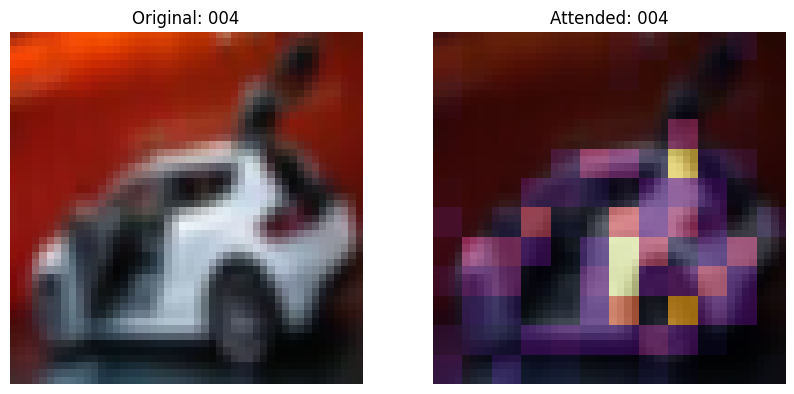

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.6651 - top-5-accuracy: 0.9662 - loss: 0.0747 - val_loss: 0.0816
Epoch 6/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 62s 16ms/step - accuracy: 0.6892 - top-5-accuracy: 0.9638 - loss: 0.0535 - val_loss: 0.0516
Epoch 7/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.7221 - top-5-accuracy: 0.9743 - loss: -0.0218 - val_loss: 0.0234
Epoch 8/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.7330 - top-5-accuracy: 0.9819 - loss: -0.1091 - val_loss: -0.1131
Epoch 9/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.7581 - top-5-accuracy: 0.9819 - loss: -0.1625 - val_loss: -0.1364
Epoch 10/50
3997/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7820 - top-5-accuracy: 0.9860 - loss: -0.1891

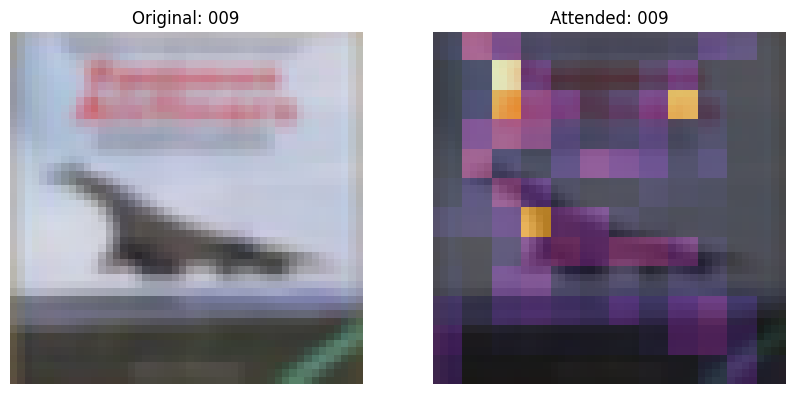

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.7709 - top-5-accuracy: 0.9838 - loss: -0.1916 - val_loss: -0.2226
Epoch 11/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.7367 - top-5-accuracy: 0.9824 - loss: -0.2062 - val_loss: -0.1809
Epoch 12/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 64s 16ms/step - accuracy: 0.7715 - top-5-accuracy: 0.9861 - loss: -0.2249 - val_loss: -0.2111
Epoch 13/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.7922 - top-5-accuracy: 0.9879 - loss: -0.2277 - val_loss: -0.2374
Epoch 14/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8080 - top-5-accuracy: 0.9896 - loss: -0.2374 - val_loss: -0.2615
Epoch 15/50
3999/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8445 - top-5-accuracy: 0.9929 - loss: -0.2445

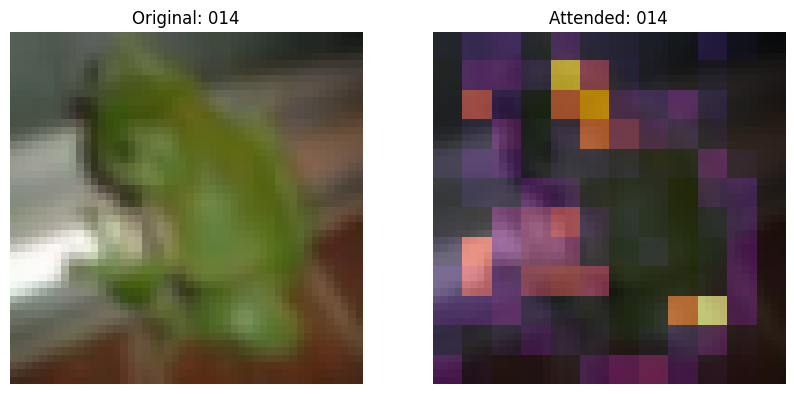

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8067 - top-5-accuracy: 0.9885 - loss: -0.2450 - val_loss: -0.2518
Epoch 16/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8021 - top-5-accuracy: 0.9886 - loss: -0.2407 - val_loss: -0.2194
Epoch 17/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8041 - top-5-accuracy: 0.9870 - loss: -0.2589 - val_loss: -0.1756
Epoch 18/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8157 - top-5-accuracy: 0.9907 - loss: -0.2485 - val_loss: -0.2263
Epoch 19/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8200 - top-5-accuracy: 0.9893 - loss: -0.2560 - val_loss: -0.2510
Epoch 20/50
3998/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8821 - top-5-accuracy: 0.9963 - loss: -0.2800

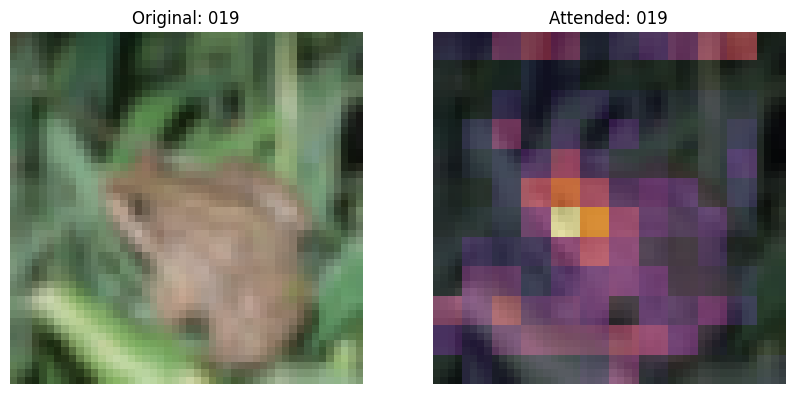

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 64s 16ms/step - accuracy: 0.8285 - top-5-accuracy: 0.9899 - loss: -0.2904 - val_loss: -0.2779
Epoch 21/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 64s 16ms/step - accuracy: 0.8379 - top-5-accuracy: 0.9909 - loss: -0.3084 - val_loss: -0.2887
Epoch 22/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8200 - top-5-accuracy: 0.9914 - loss: -0.3166 - val_loss: -0.2619
Epoch 23/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8407 - top-5-accuracy: 0.9901 - loss: -0.3138 - val_loss: -0.2553
Epoch 24/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8360 - top-5-accuracy: 0.9912 - loss: -0.3067 - val_loss: -0.3029
Epoch 25/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9131 - top-5-accuracy: 0.9984 - loss: -0.3130

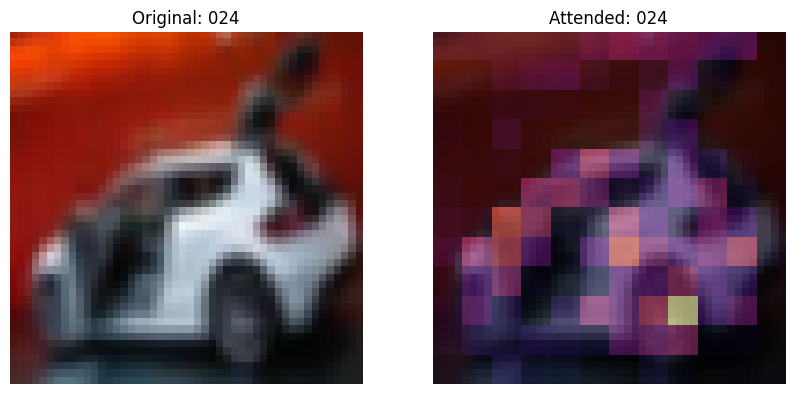

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8379 - top-5-accuracy: 0.9914 - loss: -0.3136 - val_loss: -0.2221
Epoch 26/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8461 - top-5-accuracy: 0.9907 - loss: -0.3310 - val_loss: -0.2432
Epoch 27/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8452 - top-5-accuracy: 0.9914 - loss: -0.3602 - val_loss: -0.3703
Epoch 28/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 64s 16ms/step - accuracy: 0.8499 - top-5-accuracy: 0.9937 - loss: -0.4017 - val_loss: -0.2650
Epoch 29/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8533 - top-5-accuracy: 0.9923 - loss: -0.4163 - val_loss: -0.4629
Epoch 30/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9387 - top-5-accuracy: 0.9992 - loss: -0.4556

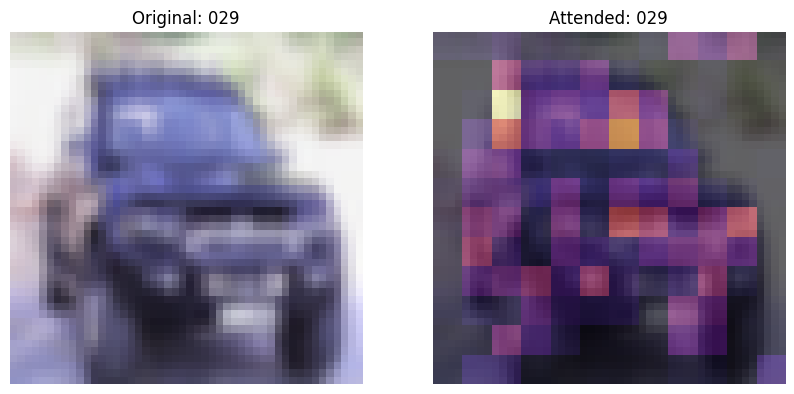

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8441 - top-5-accuracy: 0.9923 - loss: -0.4599 - val_loss: -0.4134
Epoch 31/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8482 - top-5-accuracy: 0.9929 - loss: -0.5397 - val_loss: -0.5868
Epoch 32/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8502 - top-5-accuracy: 0.9939 - loss: -0.5003 - val_loss: -0.4333
Epoch 33/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8552 - top-5-accuracy: 0.9929 - loss: -0.5690 - val_loss: -0.5506
Epoch 34/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8581 - top-5-accuracy: 0.9935 - loss: -0.6191 - val_loss: -0.6138
Epoch 35/50
3998/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9622 - top-5-accuracy: 0.9999 - loss: -0.6585

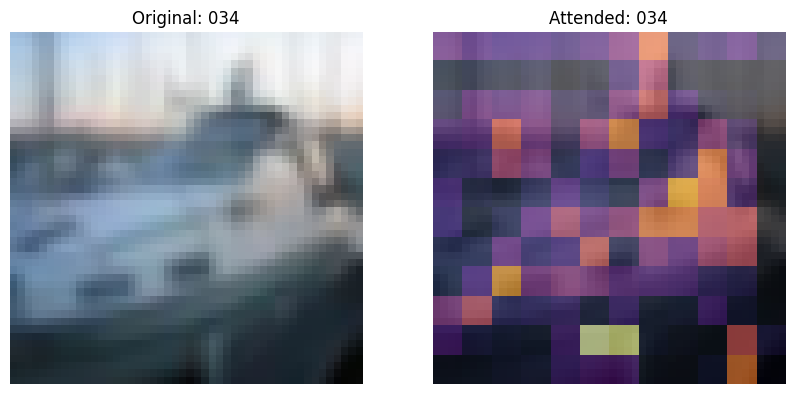

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8578 - top-5-accuracy: 0.9927 - loss: -0.6462 - val_loss: -0.6386
Epoch 36/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8609 - top-5-accuracy: 0.9938 - loss: -0.7426 - val_loss: -0.7122
Epoch 37/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8570 - top-5-accuracy: 0.9943 - loss: -0.8450 - val_loss: -0.9600
Epoch 38/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8562 - top-5-accuracy: 0.9930 - loss: -0.8769 - val_loss: -0.8310
Epoch 39/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8645 - top-5-accuracy: 0.9934 - loss: -0.9466 - val_loss: -0.9943
Epoch 40/50
3997/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9770 - top-5-accuracy: 0.9997 - loss: -0.9805

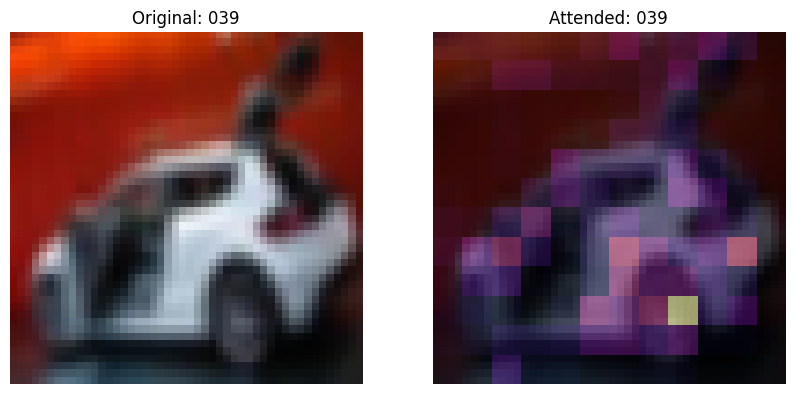

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8598 - top-5-accuracy: 0.9936 - loss: -0.9811 - val_loss: -1.0045
Epoch 41/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8670 - top-5-accuracy: 0.9932 - loss: -1.0840 - val_loss: -1.0612
Epoch 42/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8678 - top-5-accuracy: 0.9932 - loss: -1.1199 - val_loss: -1.1523
Epoch 43/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8687 - top-5-accuracy: 0.9932 - loss: -1.1909 - val_loss: -1.1794
Epoch 44/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8695 - top-5-accuracy: 0.9932 - loss: -1.2169 - val_loss: -1.1392
Epoch 45/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9868 - top-5-accuracy: 1.0000 - loss: -1.2071

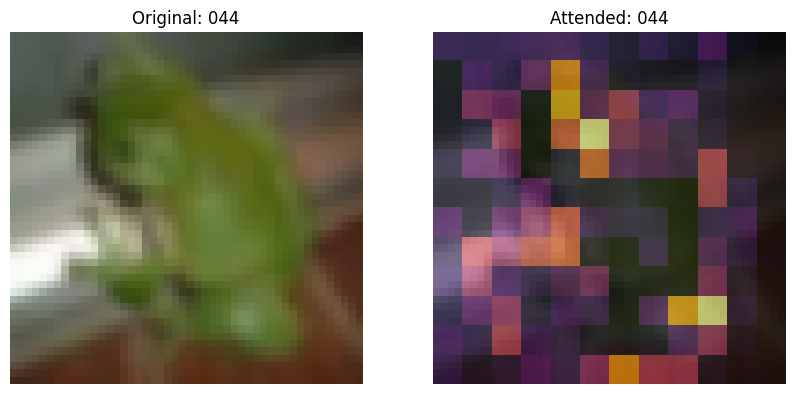

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8704 - top-5-accuracy: 0.9937 - loss: -1.2350 - val_loss: -1.2062
Epoch 46/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8702 - top-5-accuracy: 0.9936 - loss: -1.3094 - val_loss: -1.2741
Epoch 47/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8704 - top-5-accuracy: 0.9936 - loss: -1.3354 - val_loss: -1.2537
Epoch 48/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8688 - top-5-accuracy: 0.9933 - loss: -1.3460 - val_loss: -1.2632
Epoch 49/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8703 - top-5-accuracy: 0.9935 - loss: -1.3653 - val_loss: -1.2720
Epoch 50/50
3999/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9885 - top-5-accuracy: 1.0000 - loss: -1.3625

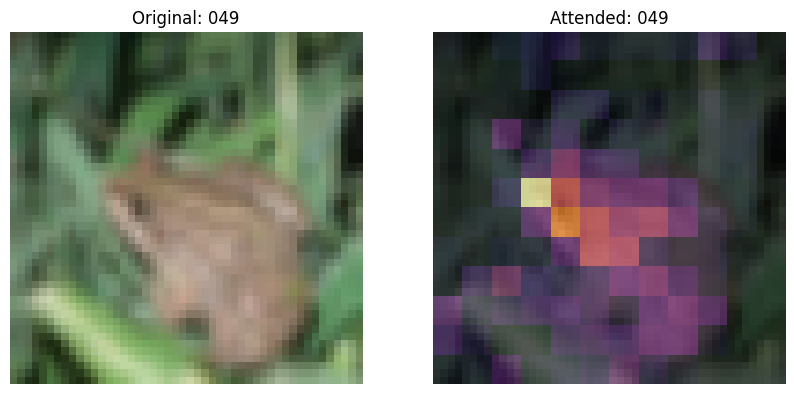

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - accuracy: 0.8702 - top-5-accuracy: 0.9934 - loss: -1.3591 - val_loss: -1.2660
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8655 - top-5-accuracy: 0.9927 - loss: -1.2409


ValueError: not enough values to unpack (expected 3, got 2)

In [11]:
train_augmentation_model = get_train_augmentation_model()
preprocessing_model = get_preprocessing()
conv_stem = build_convolutional_stem(dimensions=DIMENSIONS)
conv_trunk = Trunk(depth=TRUNK_DEPTH, dimensions=DIMENSIONS, ratio=SE_RATIO)
attention_pooling = AttentionPooling(dimensions=DIMENSIONS, num_classes=NUM_CLASSES)

patch_conv_net = PatchConvNet(
    stem=conv_stem,
    trunk=conv_trunk,
    attention_pooling=attention_pooling,
    train_augmentation_model=train_augmentation_model,
    preprocessing_model=preprocessing_model,
)

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]
# Get the optimizer.
optimizer = keras.optimizers.AdamW(
    learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY
)
# Compile and pretrain the model.
patch_conv_net.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
history = patch_conv_net.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=train_callbacks,
)

# Evaluate the model with the test dataset.
loss, acc_top1, acc_top5 = patch_conv_net.evaluate(test_ds)
print(f"Loss: {loss:0.2f}")
print(f"Top 1 test accuracy: {acc_top1*100:0.2f}%")
print(f"Top 5 test accuracy: {acc_top5*100:0.2f}%")

      0/Unknown 0s 0s/step

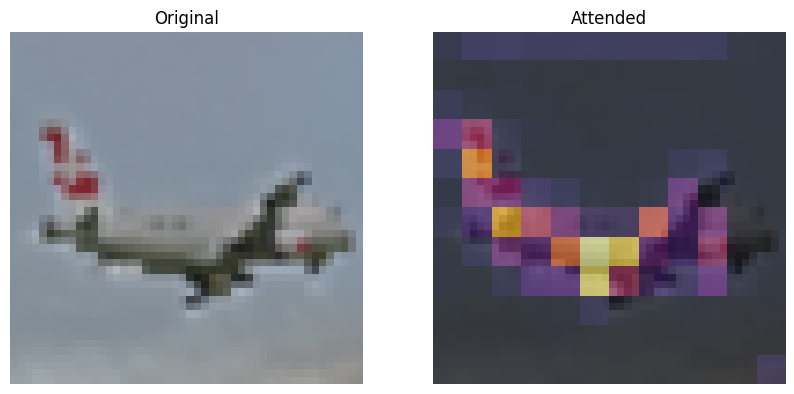

In [12]:
def plot_attention(image):
    """Plots the attention map on top of the image.

    Args:
        image: A numpy image of arbitrary size.
    """
    # Resize the image to a (32, 32) dim.
    image = ops.image.resize(image, (32, 32))
    image = image[np.newaxis, ...]
    test_augmented_images = patch_conv_net.preprocessing_model(image)
    # Pass through the stem.
    test_x = patch_conv_net.stem(test_augmented_images)
    # Pass through the trunk.
    test_x = patch_conv_net.trunk(test_x)
    # Pass through the attention pooling block.
    _, test_viz_weights = patch_conv_net.attention_pooling(test_x)
    test_viz_weights = test_viz_weights[np.newaxis, ...]
    # Reshape the vizualization weights.
    num_patches = ops.shape(test_viz_weights)[-1]
    height = width = int(math.sqrt(num_patches))
    test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
    selected_image = test_augmented_images[0]
    selected_weight = test_viz_weights[0]
    # Plot the images.
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(selected_image)
    ax[0].set_title(f"Original")
    ax[0].axis("off")
    img = ax[1].imshow(selected_image)
    ax[1].imshow(selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent())
    ax[1].set_title(f"Attended")
    ax[1].axis("off")
    plt.axis("off")
    plt.show()
    plt.close()


url = "http://farm9.staticflickr.com/8017/7140384795_385b1f48df_z.jpg"
image_name = keras.utils.get_file(fname="image.jpg", origin=url)
image = keras.utils.load_img(image_name)
image = keras.utils.img_to_array(image)
plot_attention(image)